In [1]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
from urllib.parse import urlparse, urljoin
from collections import deque

default_intra_depth = 20

def extract_links(url, main_domain):
    response = requests.get(url)
    try:
        soup = BeautifulSoup(response.text, 'html.parser')
    except Exception as e:
        print(f"Assertion error on {url}, with {response.text} : {e}")
        return []
    links = []
    for a in soup.find_all('a', href=True):
        link = a.get('href')
        if link:
            try:
                absolute_url = urljoin(url, link)
                parsed_url = urlparse(absolute_url)
                # Check if the link belongs to the main domain
                if parsed_url.scheme != 'mailto':
                    # faut-il explorer les autres pages d'un même domaine ou mettre un filtre
                    # main_domain != parsed_url.netloc ?
                    links.append(absolute_url)
            except ValueError as e:
                print(f"ValueError for {link} : {e}")
    
    return links

def build_network(seed_urls, outer_depth=1, intra_depth=default_intra_depth, domain_to_exclude=[]):
    graph = nx.Graph()
    queue = deque()
    for seed_url in seed_urls:
        queue.append((seed_url, outer_depth, intra_depth)) 
    visited_pages_by_domain = {}  # Dictionary to track visited pages for each domain (in intra page)

    while queue:
        current_url, current_outer_depth, current_intra_depth = queue.popleft()

        # On arrête l'exploration quand on est suffisamment allé dans un sens.
        if current_outer_depth == 0 or current_intra_depth == 0:
            continue

        try:
            domain = urlparse(current_url).netloc
            if domain in domain_to_exclude:
                continue

            if domain not in graph.nodes:
                graph.add_node(domain)
            if domain not in visited_pages_by_domain:
                visited_pages_by_domain[domain] = set()

            links = extract_links(current_url, domain)
            for link in links:
                parsed_url = urlparse(link)
                linked_domain = parsed_url.netloc

                if linked_domain in domain_to_exclude:
                    continue
                new_domain = False
                if linked_domain not in graph.nodes:
                    new_domain = True
                    graph.add_node(linked_domain)

                if linked_domain not in visited_pages_by_domain:
                        visited_pages_by_domain[linked_domain] = set()

                if domain != linked_domain:
                    if graph.has_edge(domain, linked_domain):
                        graph[domain][linked_domain]['weight'] += 1
                    else:
                        graph.add_edge(domain, linked_domain, weight=1)
                    base_url = f"{parsed_url.scheme}://{linked_domain}"

                    if new_domain:
                        queue.append((base_url, current_outer_depth - 1, default_intra_depth))
                else:
                    if current_intra_depth > 0 and link not in visited_pages_by_domain[domain]:
                        queue.append((link, current_outer_depth, current_intra_depth - 1))
                        visited_pages_by_domain[domain].add(link)
        except requests.exceptions.RequestException as e:
            print(f"Error processing {current_url}: {e}, for domain : {urlparse(current_url)}, for URL : {current_url}, for depth : {current_outer_depth}")

    return graph


In [2]:
nodes_to_exclude = [
    'www.helloasso.com',
    'www.youtube.com',
    'www.facebook.com',
    'www.instagram.com',
    'twitter.com',
    'www.tumblr.com',
    'pinterest.com',
    'www.tiktok.com',
    'www.linkedin.com',
    'play.google.com',
    'apps.apple.com',
    'support.google.com',
    'support.microsoft.com',
    'support.apple.com',
    'support.mozilla.org',
    'youtu.be',
    'www.pinterest.fr',
    'digital4u.com',
    'www.google.com',
    'www.imdb.com',
    'www.mesopinions.com',
    'drive.google.com',
    'fr.wikipedia.com',
    't.co',

    'www.reddit.com',
    'www.amazon.com',
    'www.netflix.com',
    'www.ebay.com',
    'www.quora.com',
    'www.walmart.com',
    'www.target.com',
    'www.bestbuy.com',
    'www.spotify.com',
    'www.apple.com',
    'www.microsoft.com',
    'www.yahoo.com',
    'www.bing.com',
    'www.ask.com',
    'www.cnn.com',
    'www.bbc.com',
    'www.nytimes.com',
    'www.wsj.com',
    'www.foxnews.com',
    'www.cbsnews.com',
    'www.nbcnews.com',
    'www.huffpost.com',
    'www.buzzfeed.com',
    'www.theguardian.com',
    'www.usatoday.com',
    'www.forbes.com',
    'www.bloomberg.com',
    'www.craigslist.org',
    'www.wikipedia.org',
    'www.weather.com',
    'www.lemonde.fr',  # French newspaper "Le Monde"
    'www.lefigaro.fr',  # French newspaper "Le Figaro"
    'www.liberation.fr',  # French newspaper "Libération"
    'www.france24.com',  # French international news TV
    'www.rfi.fr',  # Radio France Internationale
    'www.euronews.com',  # European news
    'www.reuters.com',  # International news agency
    'www.apnews.com',  # Associated Press
    'www.bbc.com',  # BBC News
    'www.theguardian.com',  # The Guardian
    'www.aljazeera.com',  # Al Jazeera English
    'www.cnn.com',  # CNN
    'www.nytimes.com',  # The New York Times
    'www.wsj.com',  # The Wall Street Journal
]

nodes_to_exclude += [
    'www.rtl.be',  # Belgian news source RTL
    'www.lesoir.be',  # Belgian newspaper Le Soir
    'www.lalibre.be',  # Belgian newspaper La Libre Belgique
    'www.dhnet.be',  # Belgian newspaper La Dernière Heure
    'www.rtbf.be',  # Belgian public broadcaster RTBF
    'ici.radio-canada.ca',  # Canadian public broadcaster Radio-Canada
    'www.cyberpresse.ca',  # Canadian news source La Presse
    'www.ledevoir.com',  # Canadian newspaper Le Devoir
    'www.journaldemontreal.com',  # Canadian newspaper Le Journal de Montréal
    'www.20minutes.fr',  # French news source 20 Minutes
    'www.ouest-france.fr',  # French newspaper Ouest-France
    'www.sudouest.fr',  # French newspaper Sud Ouest
    'www.laprovence.com',  # French newspaper La Provence
    'www.leparisien.fr',  # French newspaper Le Parisien
    'www.nouvelobs.com',  # French news magazine L'Obs
    'www.lepoint.fr',  # French news magazine Le Point
    'www.lexpress.fr',  # French news magazine L'Express
    'www.lci.fr',  # French news channel LCI
    'www.tf1.fr',  # French TV channel TF1
    'www.francetvinfo.fr',  # French public news service FranceInfo
    'www.rfi.fr',  # Radio France Internationale
    'www.euronews.com',  # European news
    'www.reuters.com',  # International news agency
    'www.apnews.com',  # Associated Press
]

nodes_to_exclude += [
    # UK News
    'www.telegraph.co.uk',  # The Telegraph (UK)
    'www.independent.co.uk',  # The Independent (UK)
    'www.mirror.co.uk',  # Daily Mirror (UK)
    'www.standard.co.uk',  # Evening Standard (UK)
    'news.sky.com',  # Sky News (UK)
    'www.bbc.co.uk/news',  # BBC News (UK)

    # US News
    'www.washingtonpost.com',  # The Washington Post (US)
    'www.usatoday.com',  # USA Today (US)
    'www.latimes.com',  # Los Angeles Times (US)
    'www.chicagotribune.com',  # Chicago Tribune (US)
    'www.nbcnews.com',  # NBC News (US)
    'abcnews.go.com',  # ABC News (US)
    'www.cbsnews.com',  # CBS News (US)

    # Spanish News
    'elpais.com',  # El País (Spain)
    'www.abc.es',  # ABC (Spain)
    'www.lavanguardia.com',  # La Vanguardia (Spain)
    'www.elmundo.es',  # El Mundo (Spain)
    'www.rtve.es/noticias',  # RTVE Noticias (Spain)
    'www.eldiario.es',  # El Diario (Spain)
    'www.20minutos.es',  # 20 Minutos (Spain)
    'www.cadenaser.com',  # Cadena SER (Spain)
]


In [8]:
import pickle
recompute = True
toSave = True
separateSeed = False
list_seed_website = [
    #'https://www.lesyndicatdelafamille.fr/',
    #'https://www.observatoirepetitesirene.org',
    #'https://www.parti-reconquete.fr/'
    #'https://womensdeclaration.com/'
    'https://www.femelliste.com/'
]
list_seed_website_test = [
    'https://www.observatoirepetitesirene.org'
]

depth_of_network = 1 # nombre de domain à visiter
depth_by_domain = 5
#list_seed_website = list_seed_website_test

if recompute:
    if separateSeed:                                  
        list_graph = []
        for seed_website in list_seed_website:
            list_graph.append(build_network(seed_website, 
                                            depth_of_network,
                                            depth_by_domain, 
                                            nodes_to_exclude))
        network_graph = nx.compose_all(list_seed_website,
                                        depth_of_network,
                                        depth_by_domain, 
                                        nodes_to_exclude)
    else:
        network_graph = build_network(list_seed_website)
    if toSave:
        with open('network_graph.pkl', 'wb') as file:
            pickle.dump(network_graph, file)
else:
    with open('network_graph.pkl', 'rb') as file:
        network_graph = pickle.load(file)


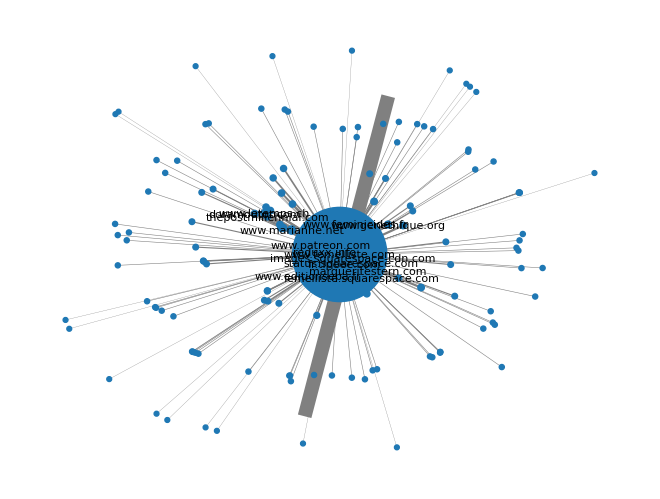

In [9]:
import matplotlib.pyplot as plt
# Nodes to exclude from the calculation

# Calculate PageRank scores excluding specified nodes
pagerank_scores_with_exclusion = nx.pagerank(network_graph.subgraph(set(network_graph.nodes) - set(nodes_to_exclude)))
pagerank_scores = nx.pagerank(network_graph)
# Get the top 10 nodes based on PageRank scores
n_top_nodes = 15
top_nodes = sorted(pagerank_scores_with_exclusion, key=pagerank_scores.get, reverse=True)[:n_top_nodes]

# Visualization with different edge sizes based on weights and labels of the top 10 nodes
pos = nx.spring_layout(network_graph, k=0.01)
edge_widths = [network_graph[u][v]['weight'] for u, v in network_graph.edges()]

# Scale down the edge widths (adjust the scaling factor as needed)
edge_widths = [width * 0.2 for width in edge_widths]

node_sizes = [pagerank_scores[node] * 10000 for node in network_graph.nodes()]

nx.draw(network_graph, pos, with_labels=False, font_weight='bold', width=edge_widths, node_size = node_sizes, edge_color='gray')

# Display labels of the top 10 nodes
labels = {node: node if node in top_nodes else '' for node in network_graph.nodes}
nx.draw_networkx_labels(network_graph, pos, labels=labels, font_size=8)

plt.show()

In [10]:
nx.set_node_attributes(network_graph, pos, 'pos')

In [11]:
import networkx as nx
import plotly.graph_objects as go

min_connections = 0 # attention c'est le seuil minimal accepté. à 1 tout est accepté.
# Filter nodes based on the minimum number of connections
filtered_nodes = [node for node, degree in network_graph.degree if degree >= min_connections]

# Create a subgraph with filtered nodes and their edges
G = network_graph.subgraph(filtered_nodes + [v for u, v in network_graph.edges() if u in filtered_nodes and v in filtered_nodes])

pos = nx.spring_layout(G)

# Add positions to the graph as node attributes
nx.set_node_attributes(G, pos, 'pos')

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_pagerank = []
node_text = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_pagerank.append(pagerank_scores[node])
    node_text.append(f'Node: {node}<br>PageRank score: {pagerank_scores[node]}')    

node_adjacencies = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text = node_text,
    customdata = list(G.nodes()),
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=node_adjacencies,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Plotly layout
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Network graph made with Python',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

## Sites identifiés : 
### A partir d'observatoire de la petite sirène
dragonbleutv.com : 'psychanalyse'
ypomoni.org
cryforrecognition.be
https://christineld75.wordpress.com/,

Un site de pétition (peut être on pourrait chercher à récupérer les textes de pétitions ?)

Beaucoup de sites anglophones, de site de médias et de site de journaux  scientifiques. Je me demande comment intégrer ces référents externes qui participent clairement aux discours.

### A partir du syndicat de la famille
https://www.institutemilieduchatelet.org/ : Ne parait pas du tout dans le sens de LMPT (https://fr.wikipedia.org/wiki/Institut_%C3%89milie-du-Ch%C3%A2telet). Même question qu'au dessus finalement, comment ces références scientifiques sont intégrés dans le discours anti trans ? Les nodes liées n'ont aucun intérêt.

Media : 
L'Incorrect : Avis de Fynch : Media d'extrême droite

### A partir de Reconquête
Lien avec site d'Eric Zemmour et/ou Reconquête. le reste : Semble être des accessoires.

Remarque : on voit souvent lien vers réseaux sociaux ou entreprise de com => Signe d'entrepreunariat clair de cause et de volonté de diffusion 

Réflexion : est ce qu'on pourrait pas faire une analyse en mode ? si en anglais ? Site basé scientifique ?